# Сегментация космических объектов 

## Загрузка данных

Для комфортной хагрузки данных добавьте ярлык папки Final_dataset (https://drive.google.com/drive/u/0/folders/1Q1wR9aBFCyeFEYa3wwyXNu9wk_fZdzUm) к себе на диск.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
#!ls drive/MyDrive/data/Sattelites_segmentation/Final_dataset/images/train

In [3]:
# img_resize_3110_mask.png
# img_resize_3110.png

In [4]:
#!ls drive/MyDrive/data/Sattelites_Segmentation_Final_dataset/mask/train/

In [5]:
images_path = 'F:/YandexDisk/Skill_Factory/CV-13 Segmentation/Final_dataset/images/'
mask_path = 'F:/YandexDisk/Skill_Factory/CV-13 Segmentation/Final_dataset/mask/'

## Импортируем нужные библиотеки

In [6]:
#%%capture out
#!pip install albumentations torchmetrics pytorch_lightning -U
#!pip install opencv-python-headless==4.5.2.52

In [111]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import ( EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

#from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.auto import tqdm

import segmentation_refinement as refine

import pandas as pd

import torchvision.transforms as T

In [8]:
#!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

In [9]:
from PIL import Image
from torchmetrics import JaccardIndex
from torchmetrics.classification  import MulticlassJaccardIndex

Посмотрим как выглядят исходные данные само изображение спутника и маска

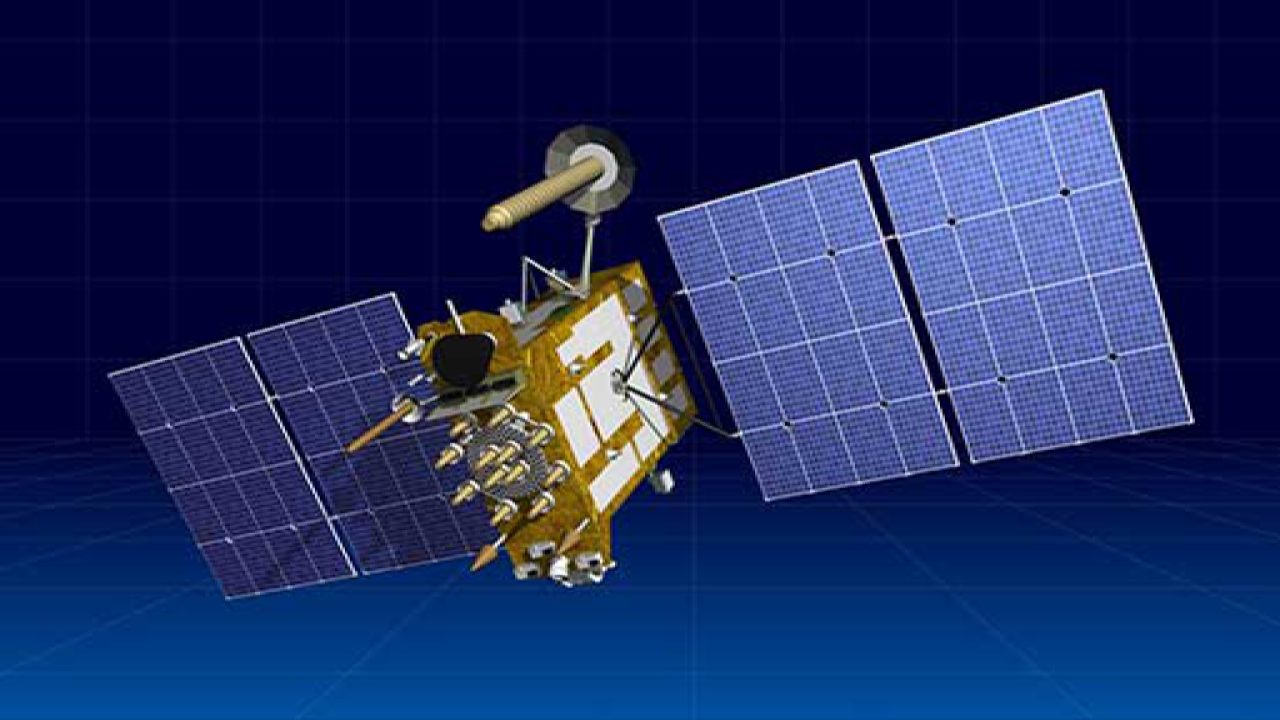

In [10]:
Image.open(images_path + 'train/' + 'img_resize_1007.png')

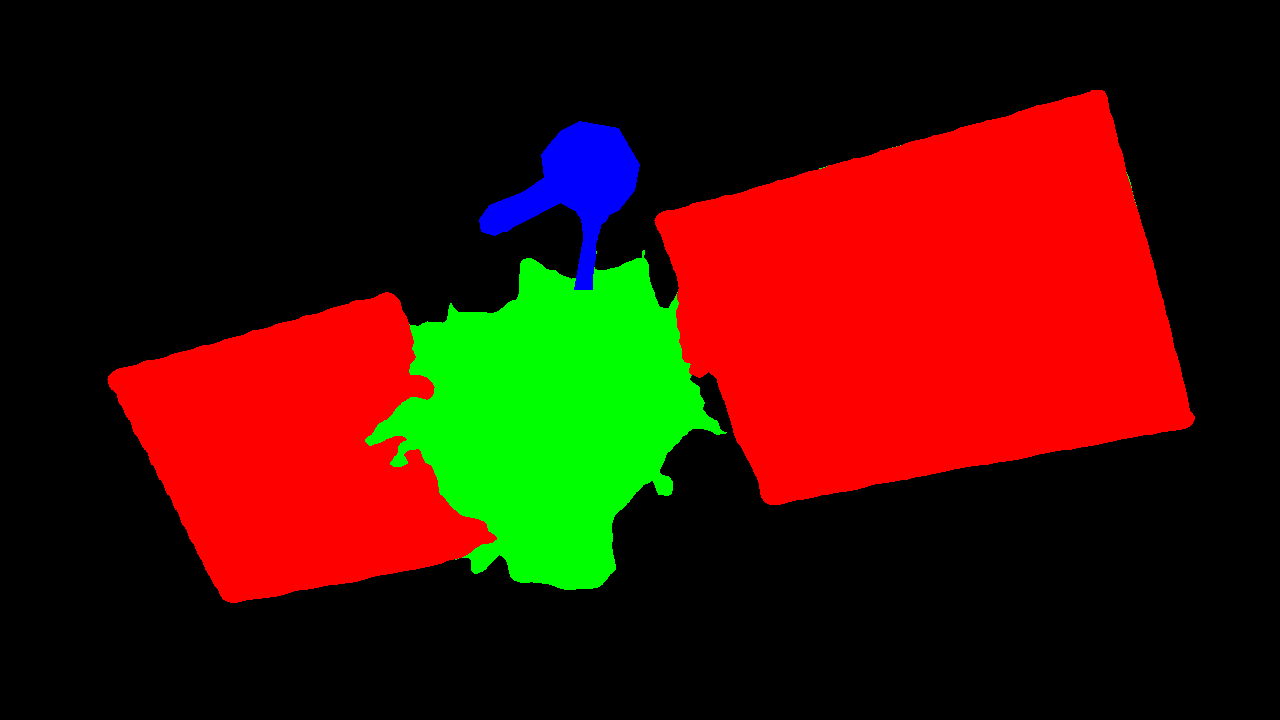

In [11]:
mask = Image.open(mask_path + 'train/' + 'img_resize_1007_mask.png')
mask

Всего 3 типа объектов:  
красный - Солнечная батарея  
зеленый - корпус  
синий - антенны    
*Примечание*: на некоторох фотографиях есть только 1 или 2 типиа объектов  

In [12]:
# Classes by Color in masks: black - background, 
# red - solar panel, green - body, blue - antenna

SAT_COLORMAP = [[0, 0, 0], [0, 255, 0], [255, 0, 0], [0, 0, 255]]
SAT_CLASSES = ['background', 'body', 'solar_panel', 'antenna']

In [13]:
def preprocess_mask(rgb_mask, colormap, background=False):
    """
    Преобразовывает маску в массив numpy
    """
    output_mask = []

    if background == False:
        colormap = colormap[1:]
    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)
  
    output_mask = np.stack(output_mask, axis=-1)
    output_mask = output_mask * np.ones(output_mask.shape)

    if background == True:
    
      output_mask = np.argmax(output_mask * [0,1,2,3], axis=-1)
      output_mask[(output_mask==2)|(output_mask==3)] = 1

    return output_mask


In [348]:
def display_few_examples_from_data(dataset, n=4, selected = None):
    """
    Отображает пары изображение - маска
    """
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 12))
    if selected == None:
        n = [i for i in range(n)]
    else:
        n = selected

    for i, im_num in enumerate(n):
        image, mask = dataset.__getitem__(im_num)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()
    #Ваш код здесь

In [15]:
fine_images = [i for i in range(0,403,1)]
coarse_images = [i for i in range(1003, 3117,1)]
val_images = [i for i in range(403,1003, 1)]

В датасете кроме чистовых масок (индексы 0-403), также есть черновые, в которых фон выделен грубее, но разделение между сегментами верное (инжексы 1003-3117). Маски в валидационном датасете (все чистовые) имеют индесы 403-1003.    

Виден дисбаланс между чистовыми и черновыми масками, последних гораздо больше. На первом этапе улучишм качество на черновых масках. Можно отдельно обучить модель и улучшить фон, можно использовать предобученную модель, что интересней.    
<BR>  
Для этих целей используем сеть CascadePSP (https://github.com/hkchengrex/CascadePSP), прогоним все изображения из черновых масок и сохраним в папку Refine, для улучшения быстродействия.  

In [12]:
#!pip install segmentation-refinement
import pickle

In [ ]:
# model_path can also be specified here
# This step takes some time to load the model

refiner = refine.Refiner(device='cuda:0') # device can also be 'cpu'

In [16]:
images_filenames = ["img_resize_"+str(i)+'.png' for i in coarse_images]
masks_filenames = ["img_resize_"+str(i)+'_mask.png' for i in coarse_images]

In [17]:
def refine_mask(idx, colormap=SAT_COLORMAP):
    image_filename = images_filenames[idx]
    image = cv2.imread(os.path.join(images_path, 'train', image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    # read mask from file 
    mask_filename = masks_filenames[idx]
    mask = cv2.imread(os.path.join(mask_path, 'train', mask_filename))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask_bg = preprocess_mask(mask, SAT_COLORMAP, background=True)
            
    mask_bg = mask_bg * np.ones(mask_bg.shape) * 255 # to black-white
    mask_bg = refiner.refine(image, mask_bg, fast=False, L=1280) 
    mask_bg = mask_bg / 255
    mask_bg[mask_bg>0.5] = 1
                    
            
    n_dims = len(SAT_COLORMAP) - 1  # без бэкграунда
            
    mask_bg = np.repeat(mask_bg[:, :, np.newaxis], n_dims, axis=2) # добавляем измерения
            
    mask = preprocess_mask(mask, SAT_COLORMAP) # сразу выводим маску 
    mask = mask * np.ones(mask.shape) * mask_bg
            
    mask = mask.astype(np.uint8)
    
    mask = mask * 255
    
    mask = mask[:,:,[1,0,2]]
    return mask

In [ ]:
for idx in coarse_images:
    output_mask = refine_mask(idx)
    mask_filename = masks_filenames[idx]
    #print(mask_filename)
    #plt.imshow(T.ToPILImage()(output_mask),interpolation="nearest")
    #plt.show()
    path_to_save = os.path.join(mask_path, 'train-refine', mask_filename)
    cv2.imwrite(path_to_save, cv2.cvtColor(output_mask, cv2.COLOR_BGR2RGB))

In [17]:
class SattDataset(Dataset):
    def __init__(self, split='train', image_type ='all', transform=None, refine=True):
        
        """
        split = train/val - какой датасет train или val
        
        image_type - типы масок: 
            fine - чистовые
            coarse - черновые
            all - все 
        
        transform - transform, по умолчанию
        
        refine - использовать предварительно улучшенные маски (вместо coarse) или нет:
            True - маски считываются из папки train-refine
            False - маски считываются из  train по умолчанию
    
        """

        # определяем папку train/val
        self.split = split
        self.image_type = image_type
        self.images_path = images_path + self.split
        self.mask_path = mask_path + self.split
        self.refine_mask = mask_path + 'train-refine'
        
        if self.split=='val':
            self.file_idxs = val_images
            
        elif self.split=='train' and self.image_type=='fine':
            self.file_idxs = fine_images
            
        elif self.split=='train' and self.image_type=='coarse':
            self.file_idxs = coarse_images
            
        else:
            self.file_idxs = fine_images + coarse_images

        self.images_filenames = ["img_resize_"+str(i)+'.png' for i in self.file_idxs]
        self.masks_filenames = ["img_resize_"+str(i)+'_mask.png' for i in self.file_idxs]

        if self.split == 'val':
            self.refine = False
        else:
            self.refine = refine 
            
        self.transform = transform
        
        

    def __len__(self):
        return len(self.file_idxs)

    def __getitem__(self, idx):
        
        # read image from folder
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_path, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)
        #image = image.transpose((2, 0, 1))
        
        # read mafk from file 
        mask_filename = self.masks_filenames[idx]
        if self.refine == True:
            if idx>403:
                mask = cv2.imread(os.path.join(self.refine_mask, mask_filename))
            else:
                mask = cv2.imread(os.path.join(self.mask_path, mask_filename))
        else:
            mask = cv2.imread(os.path.join(self.mask_path, mask_filename))
          
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if mask is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        mask = preprocess_mask(mask, SAT_COLORMAP) # сразу выводим маску 
        mask = mask * np.ones(mask.shape)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]

            mask = transformed["mask"]
            mask = torch.permute(mask, (2,0,1))

        return image, mask

In [383]:
def refine_compare(imgs):
    """
    сравнивает маски из папок train и train-refine
    """
    
    figure, ax = plt.subplots(nrows=len(imgs), ncols=2, figsize=(16, 12))
    
    for i, img in enumerate(imgs):
        im = Image.open(images_path + 'train/' + 'img_resize_' + str(img) + '.png')
        mask = Image.open(mask_path + 'train/' + 'img_resize_' + str(img) + '_mask.png')
        g, r, b = mask.split()
        mask = Image.merge('RGB', (r,g,b))
        mask_rf = Image.open(mask_path + 'train-refine/' + 'img_resize_' + str(img) + '_mask.png')
        g, r, b = mask_rf.split()
        mask_rf = Image.merge('RGB', (r,g,b))
        
        ax[i, 0].imshow(im)
        ax[i, 0].imshow(mask, interpolation="nearest", alpha=0.5)
        
        ax[i, 1].imshow(im)
        ax[i, 1].imshow(mask_rf, interpolation="nearest", alpha=0.5)
    
    plt.show()

#### Сравниваем маски после улучшения

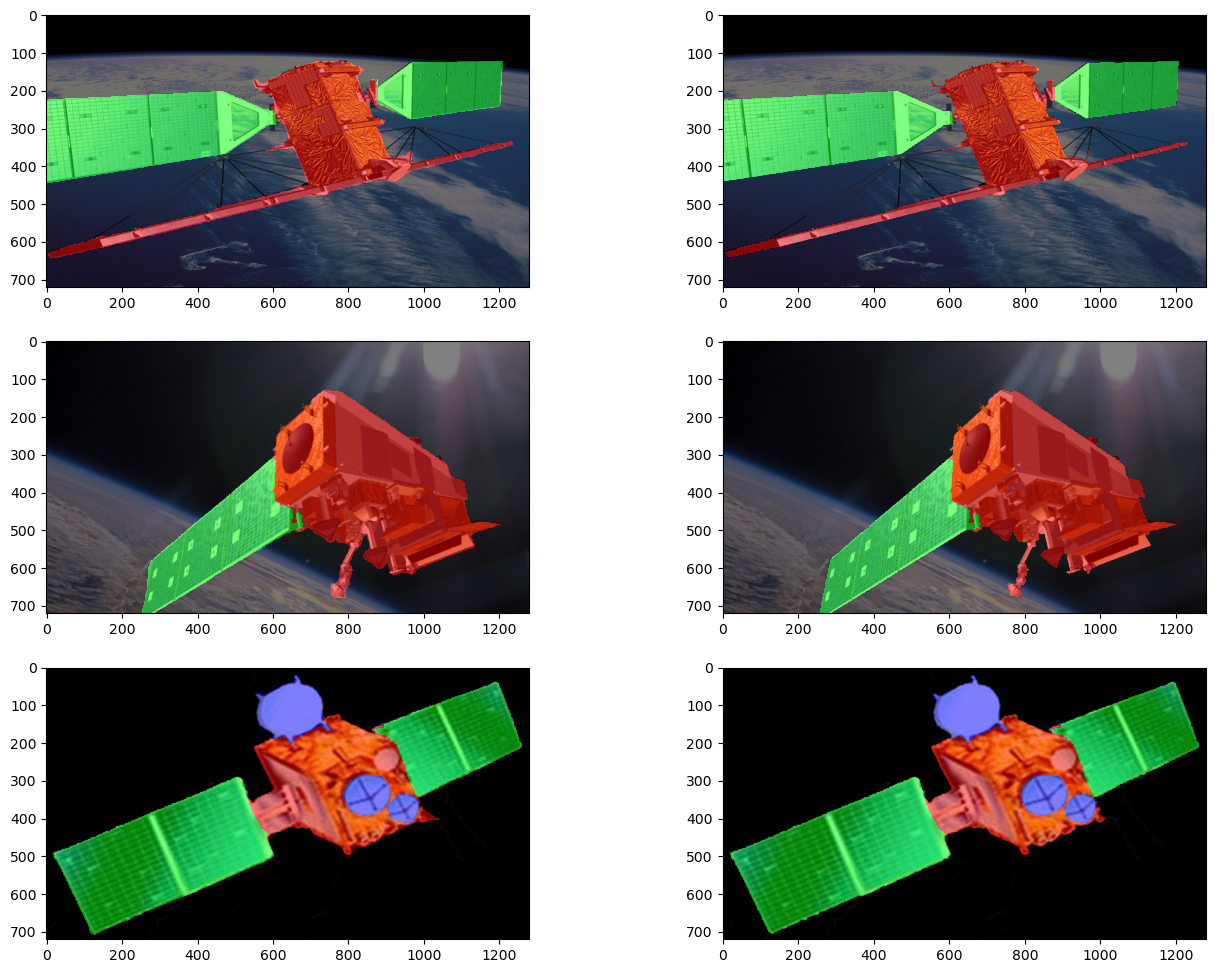

In [384]:
refine_compare([1031,1032, 1036])

на изображениях видно, что контур (между спутником и фоном) слегка улучшен. 

In [20]:
train_transform = A.Compose(
    #[A.RandomCrop(224, 384),
       [A.Resize(736, 1280),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.CoarseDropout(p=0.3),
        #A.MultiplicativeNoise(p=0.25),
        #A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=60, p=0.5),
        A.RGBShift(r_shift_limit=0, g_shift_limit=0, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.25),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
      A.Resize(736, 1280),
       A.Normalize(mean=(0.485, 0.456, 0.460), std=(0.229, 0.224, 0.225)), 
       ToTensorV2(),
     ]
)

Посмотри несколько примеров из обучающего и вадидционного датасета

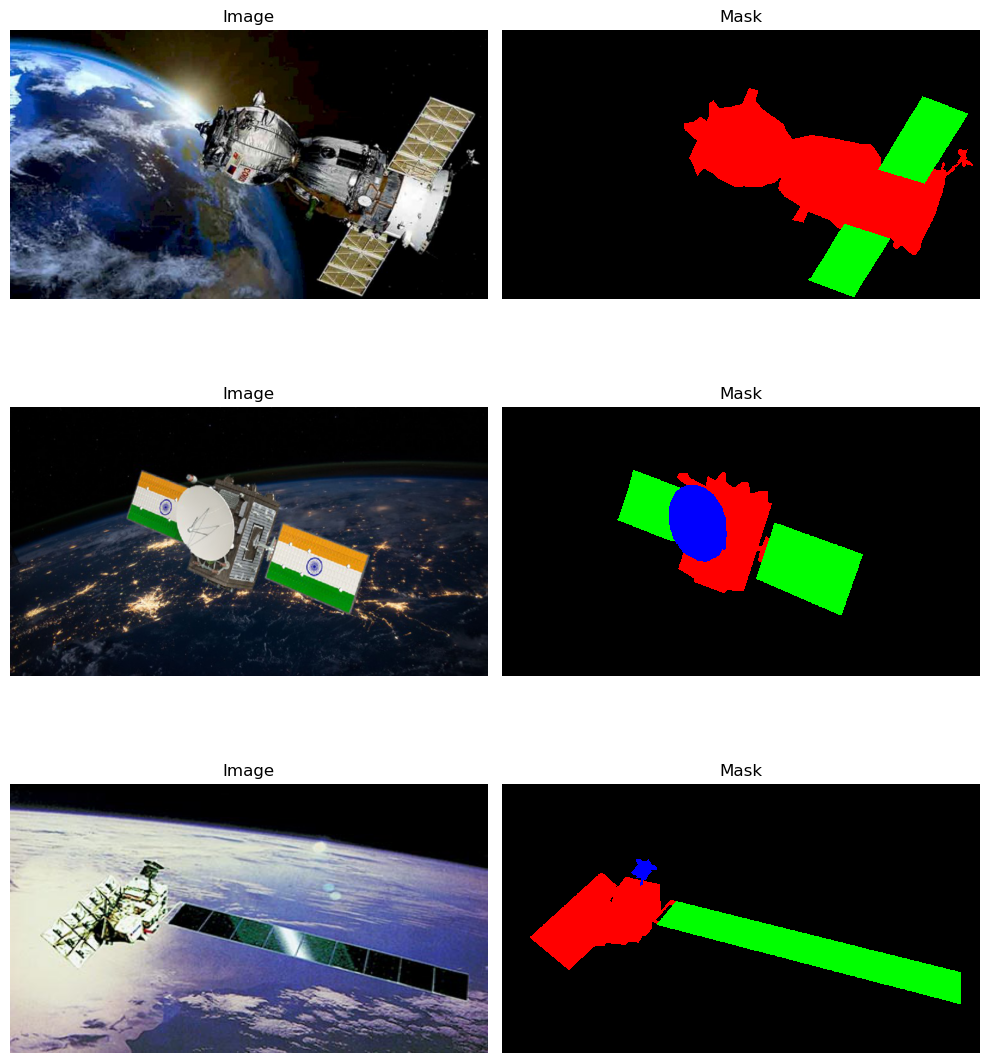

In [349]:

train_dataset = SattDataset(
    "train", image_type ='all',
    transform=None, refine=True
)

val_dataset = SattDataset("val", transform=None)

display_few_examples_from_data(train_dataset, n=3)


Validation dataset


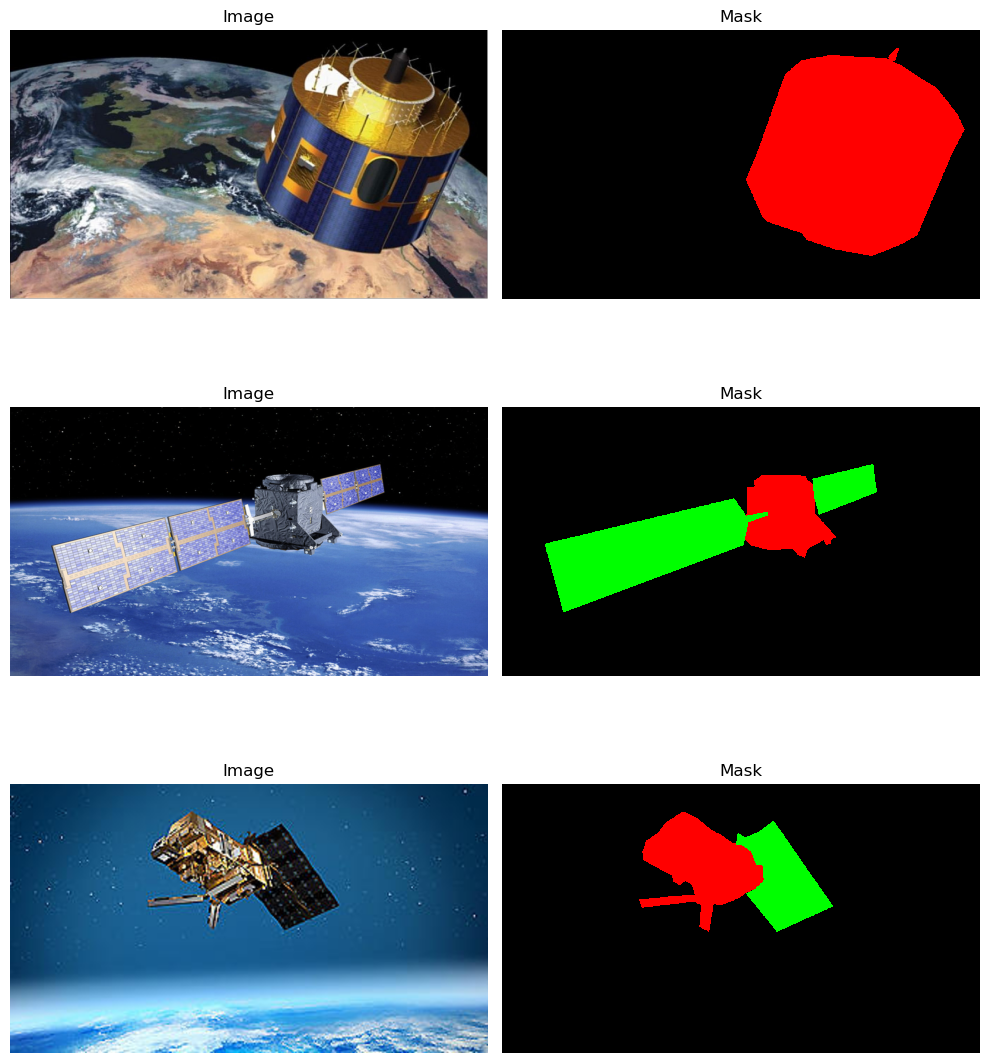

In [350]:
print("Validation dataset")
display_few_examples_from_data(val_dataset, n=3)

#### Подготавливаем модель и датасет.  
Модель возьмем предобученную **Unet** с энкодером **resnet50**. При предварительном исследовании показало точность выше чем, например FSP и DeepLab 

Метрику **JaccardIndex(mIoU)** и здесь стоит остановиться поподробней.  
Особенность расчета mIoU происходит между классами, на зображениях выше видно, что не на всех изображениях присутвуют все классы. Бывает только 2 класса или вообще один. В таких случаях IoU будет равна 0, а mIoU маскимально 0,33 (при обном классе) или 0,66 (при 2х классах). Т.е. добиться необходимой точности mIoU = 0,7  будет невозможно. Чтобы правильно работало нужно или переписать функцию и подавать каждый раз разное количество классов на вход (*num_classes*) или считать отсутвующий класс = 1 (*absent_score = 1*). В данном примере absent_score = 1

In [22]:
train_dataset = SattDataset(
    "train", image_type ='all', refine=True,
    transform=train_transform,)


val_dataset = SattDataset("val", transform=val_transform)

In [244]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = 1
        self.learning_rate = 1e-4
        self.gamma = 0.8
        
        self.net = smp.Unet(
        encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,  # model output channels (number of classes in your dataset)
        )

        self.trainset = train_dataset
        self.valset = val_dataset
        self.criterion = nn.BCEWithLogitsLoss()
        self.metric = torchmetrics.JaccardIndex(num_classes=3, average='macro', absent_score=1.0)
        

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        #batch = batch.float()
        img, mask = batch
        img = img.float()
        out = self.forward(img) # [B, 1, H, W]
        loss_val = self.criterion(out.squeeze(1), mask) # [B, 1, H, W] -> # [B, H, W]
        iou_score = self.metric(out.float(), mask.long())
        self.log("train_loss", loss_val, on_step=True)
        self.log("train_iou", iou_score, prog_bar=True, on_step=True)
        return loss_val

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=self.gamma)
        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=False, num_workers=0)
    
    def predict_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=False, num_workers=0)

    def validation_step(self, batch, batch_idx):
        #batch = batch.float()
        img, mask = batch
        img = img.float()
        out = self.forward(img)
        loss_val = self.criterion(out.squeeze(1), mask)
        iou_score = self.metric(out.float(), mask.long())
        self.log("val_loss", loss_val, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_iou", iou_score, prog_bar=True, on_step=True, on_epoch=True)
    
    def predict_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        out = self.forward(img)
        out = out.squeeze(1)
        return out

In [247]:
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger("logs", name="unet_refine_30_no_abs")

model = SegModel(train_dataset, val_dataset)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    #tpu_cores=1,
    max_epochs=30,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  # Log learning rate every epoch
    enable_progress_bar = True,
    logger=logger
)

model = model.cuda()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [340]:
trainer.fit(model)

torch.save(model.state_dict(), 'segmodel_dict_Unet_refine_30.pth')
torch.save(model, 'segmodel_unet_refine_30.pth')

### Графики обучения и метрики. 
загрузим последнюю модель и логи

In [341]:
logs = pd.read_csv("F:/YandexDisk/Skill_Factory/CV-13 Segmentation/logs/Unet_refine_30/version_0/metrics.csv")

In [342]:
logs['val_loss'] = logs['val_loss'].fillna(method='bfill')
logs['val_iou'] = logs['val_iou'].fillna(method='bfill')
logs.drop(columns=['step'], inplace=True)
logs['lr-Adam'] = logs['lr-Adam'].fillna(method='ffill')
logs.dropna(inplace=True)
logs = logs.groupby('epoch')[['train_loss', 'train_iou', 'val_loss', 'val_iou']].mean().reset_index()

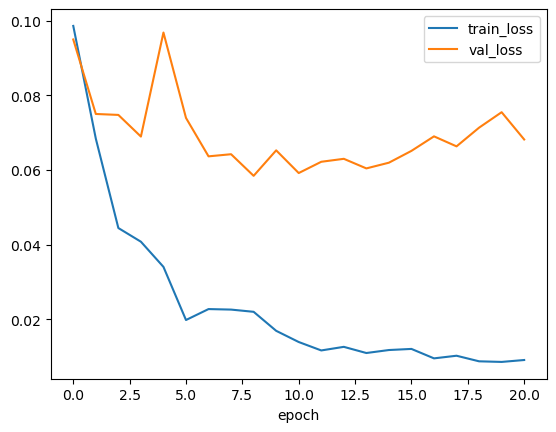

In [356]:
logs.set_index('epoch')[['train_loss', 'val_loss']].plot();

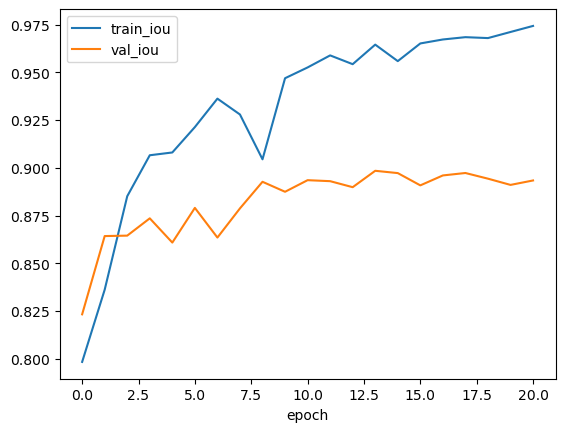

In [357]:
logs.set_index('epoch')[['train_iou', 'val_iou']].plot();

Загружаем последнюю успешную модель и делаем предикты для валидационного датасета

In [51]:
model = SegModel(train_dataset, val_dataset)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1)

#model.load_from_checkpoint('F:/YandexDisk/Skill_Factory/CV-13 Segmentation/logs/Unet_refine_30/version_6/checkpoints/epoch=14-step=37755.ckpt')
model.load_state_dict(torch.load("segmodel_dict_unet_refine_30.pth"))
model.eval();

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [249]:

val_generator = torch.utils.data.DataLoader(val_dataset)

predictions = trainer.predict(model, val_generator)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 2517it [00:00, ?it/s]

In [364]:
def pred_mask_to_np(im_num):
    npimg = predictions[im_num]
    npimg = npimg.squeeze(0).numpy()
    #npimg = npimg[[1,0,2], :]
    npimg = np.transpose(npimg, (1,2,0))
    npimg = ((npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
    return npimg

In [379]:
def val_compare(imgs):
    """
    сравнивает маски из папки val и predict
    """
    
    figure, ax = plt.subplots(nrows=len(imgs), ncols=2, figsize=(16, 4*len(imgs)))
    
    for i, img in enumerate(imgs):
        img_num_val = img+402 # номер маски в папке val с 403
        
        im = Image.open(images_path + 'val/' + 'img_resize_' + str(img_num_val) + '.png')
        im = im.resize((1280,736))
        mask = Image.open(mask_path + 'val/' + 'img_resize_' + str(img_num_val) + '_mask.png')
        mask = mask.resize((1280,736))
        g, r, b = mask.split()
        mask = Image.merge('RGB', (r,g,b))
        mask_pred = pred_mask_to_np(img-1)
        
        ax[i, 0].imshow(im)
        ax[i, 0].imshow(mask, interpolation="nearest", alpha=0.5)
        
        ax[i, 1].imshow(im)
        ax[i, 1].imshow(mask_pred, interpolation="nearest", alpha=0.5)
    
    plt.show()

### Примеры работы сети    
Будут рассмотрены несколько видов изображений и сравнены между собой из валидационного датасета (слева) и как разметила нейросеть (справа)

1. Только корпус.   
самый редкий вариант, возможно спутник или его какая-то часть.  
Корпус не всегда размечается правильно, если на нем есть "вставки" другого цвета или текстуры

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


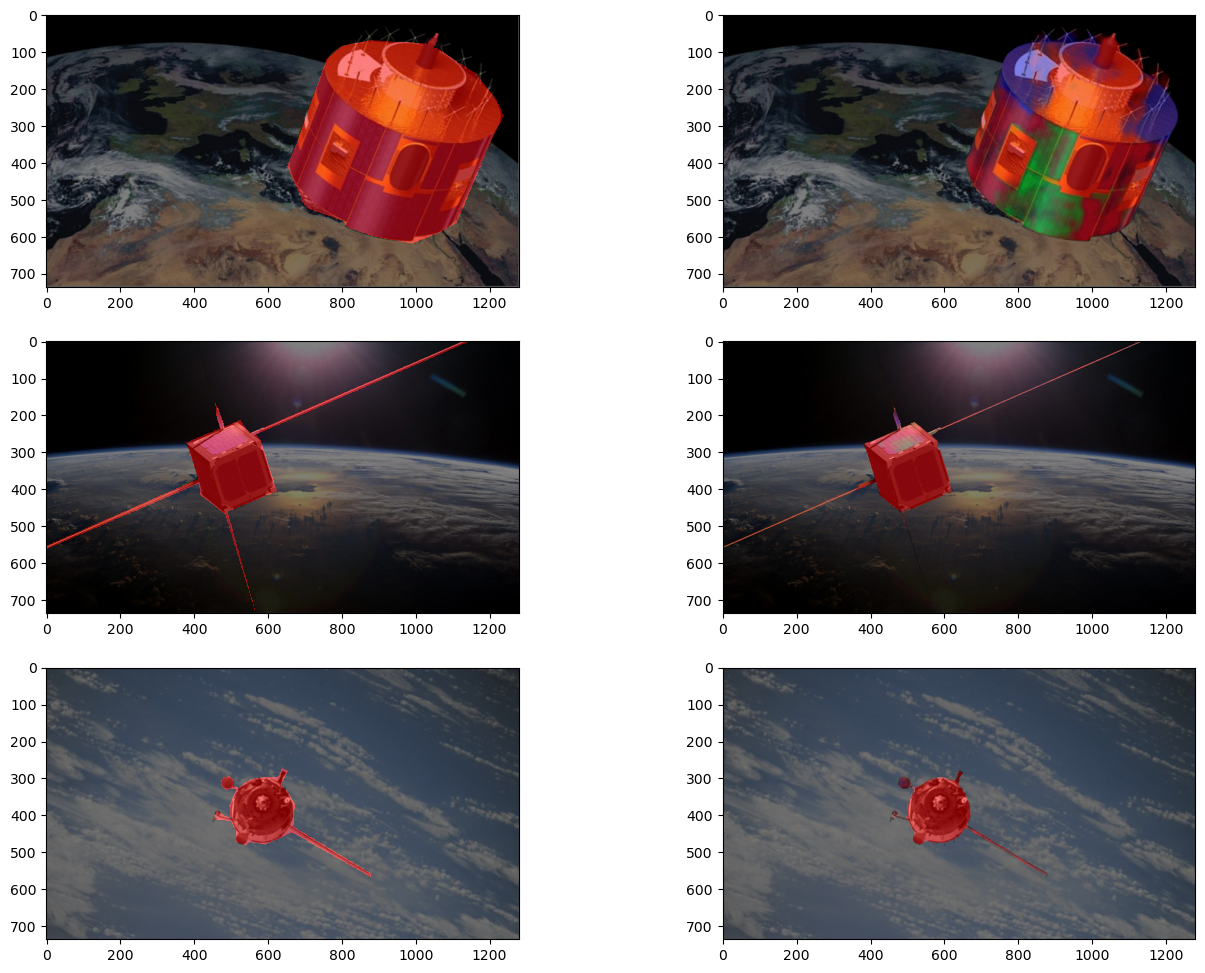

In [380]:
val_compare([1, 7, 71]);

2. Корпус и солнечные батареи.   
На таком типах спутников ошибок меньше всего. Также стоит отметить, что в валидационном датасете встречаются ошибки и крепление солнечных батарей размечено, как солнечная батарея, а не корпус. Это хорошо видно на первом и последнем изображении. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


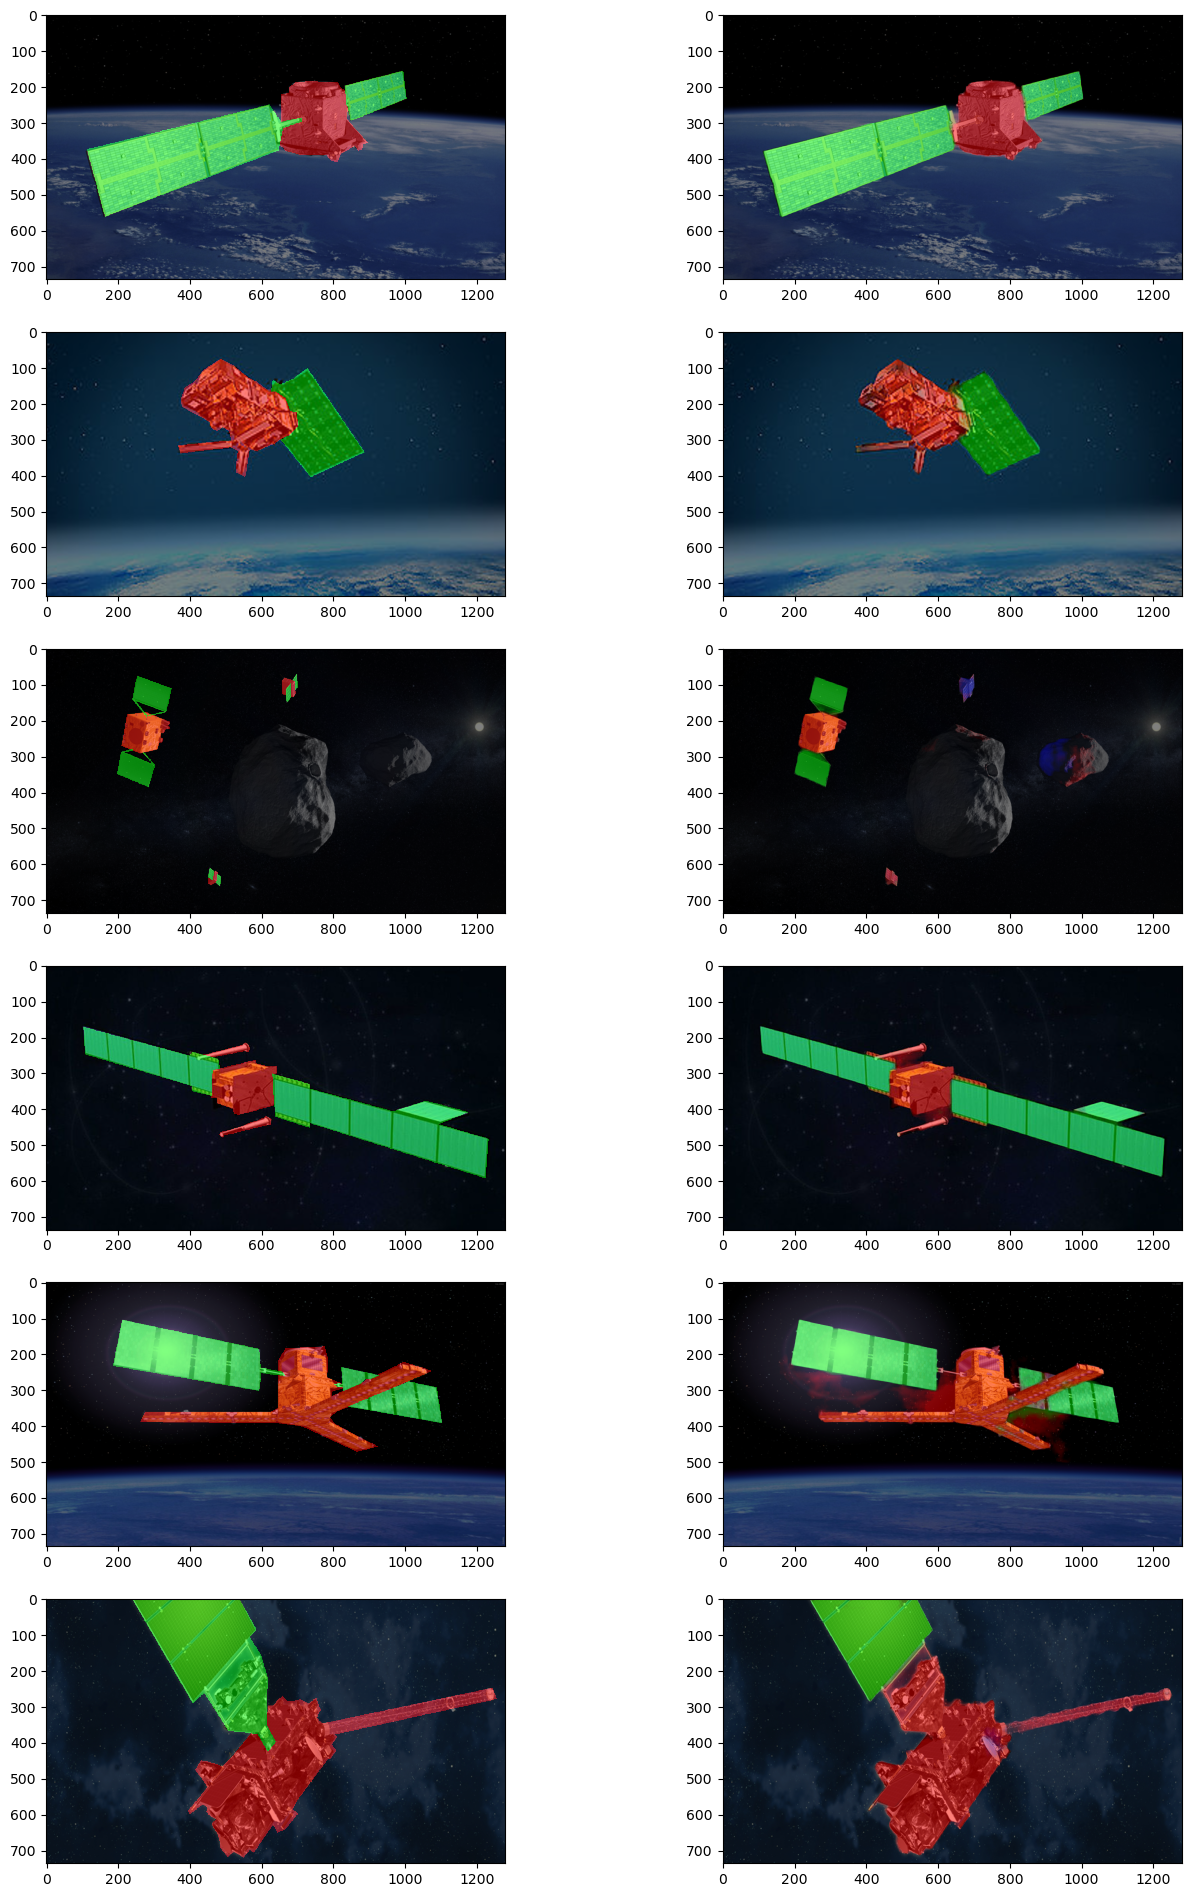

In [381]:
val_compare([2,3,4, 5,38, 58]);

3. Спутник с антеннами. 
Часто встречаются изображения с различными круглыми сенсорами, которые очень похожи на антенны, также изображений спутников с антеннами довольно мало в датасете по сравнению с другими типами.По этой причине часто антенна может быть размечена как корпус 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


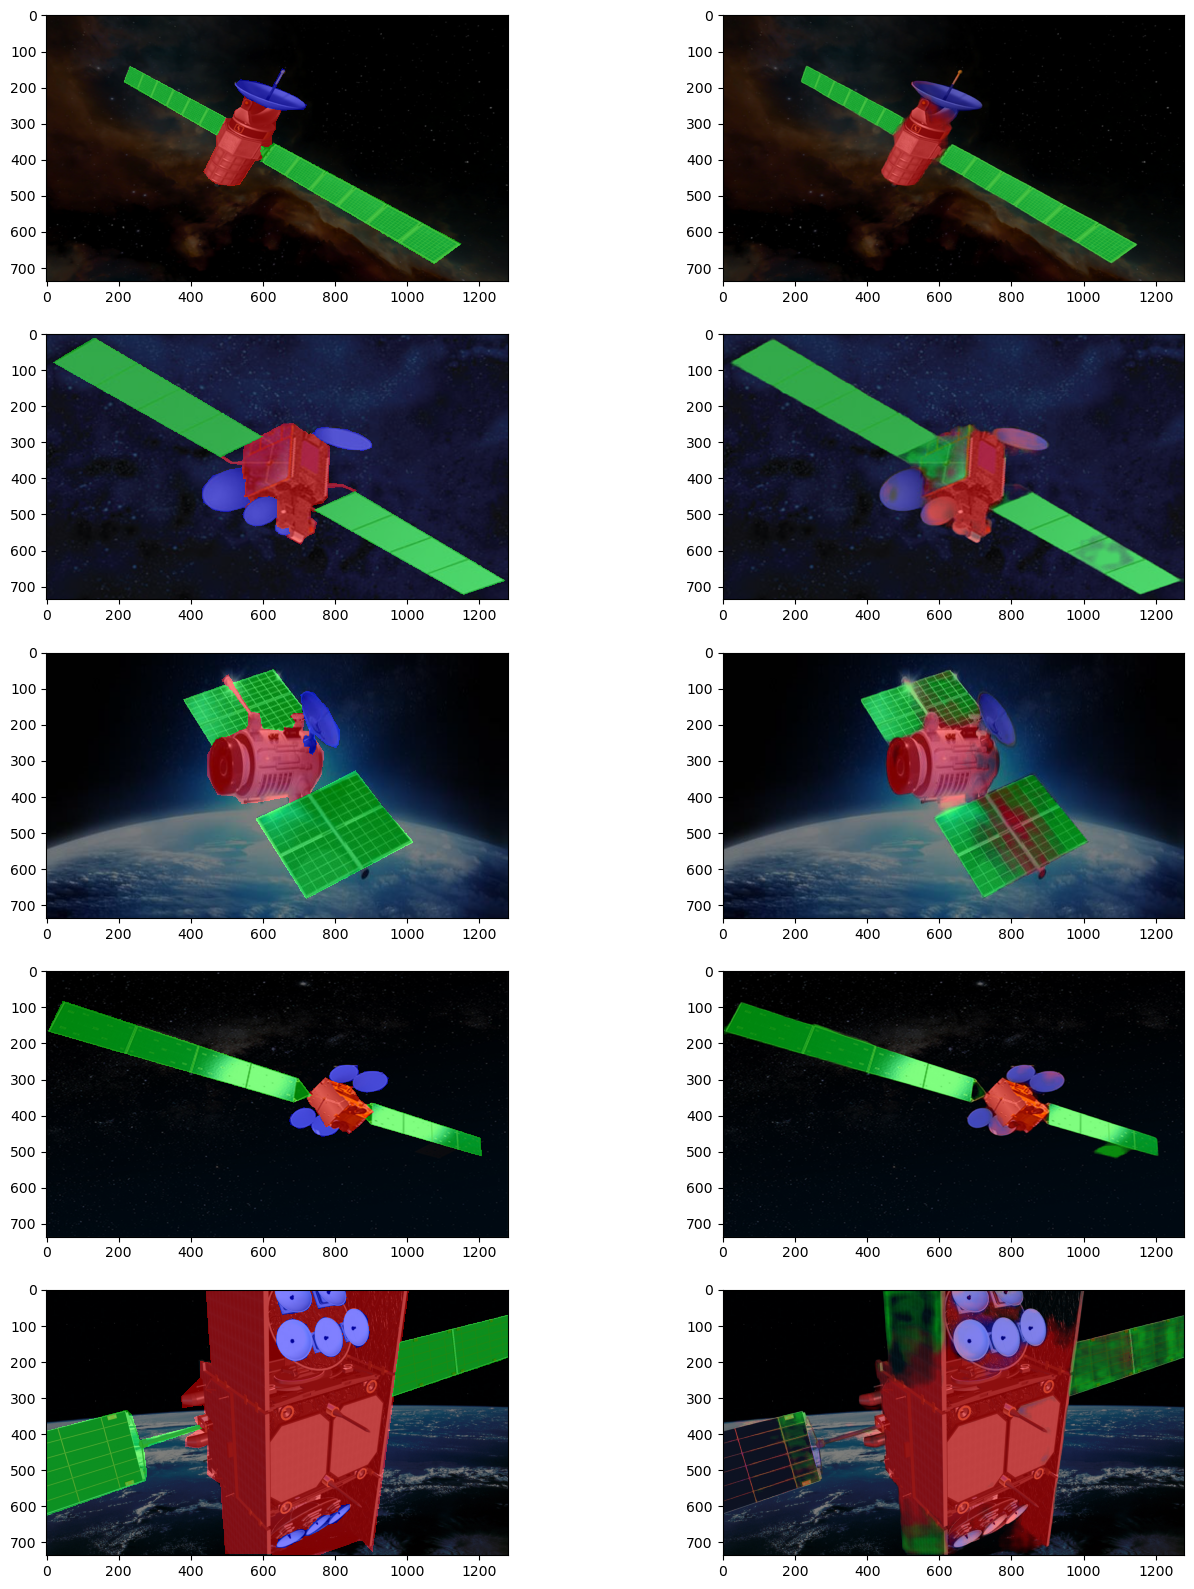

In [382]:
val_compare([10,19,23,66,76]);